# PMD Demonstrator: processing remotely hosted data 

## The scientist's view: what do we practically do?
In this Notebook, we show exemplary how *ontologically described experimental data* (tensile tests on various S355 steel specimen) may be explored and processed. The database is hosted on a remote server running ontodocker. First, a manual exploration via SPARQL-queries is shown. We follow a set of questions, "translate" them into SPARQL-queries and discuss the obtained ouput. Then, data is processed using a pyiron-workflow. After analising a single dataset, we batch-process all available datasets while avoiding the formulation of explicit SPARQL-queries by the user. Mechanical quantities are calculated ($E$-modulus, $R_{p0.2}$) and stress-strain curves are plotted.

### Provided by the user:
- A material-digital account
- A SPARQL endpoint
- An user specific API-token (generated by keycloak and retievable via the ontodocker GUI).
  For running this notebook, this token has to be copied to a file `token.txt` located in the working directory.

## The infrasturcture view
"Under the hood" this procedure can be performed for a set of scenarios:
1. **All involved computers/servers are exposed to the internet**  
    The user works on an arbitrary computer which is connected to the internet.      
    The ontological database + infrastructure (triplestore = ontodocker) is hosted on the PMD-C ([ontodocker-dev.material-digital.de](ontodocker-dev.material-digital.de)) or any PMD-S which is exposed to the internet.
    Of course, the files containing the actual data also have to be either publicly available or available within the users subnet in this situation.

2. **All involved computers are exposed within the wireguard mesh**
   In this situation, the user is working on some PMD-S instance (e.g. [pyiron.material-digital.de](pyiron.material-digital.de)). There you can either select an appropriate image (e.g. "PMD Demonstrator") or some other pre-configured conda-environment within a jupyter session. Perhaps one has to install some more packages (e.g. for running this notebook, see `environment.yml`). The datafiles may be hosted either on some server available within the mesh or on the public internet.

3. **The user works on some machine within a strongly restricted environment** (e.g. @ BAM)
   Ontodocker and the datafiles are hosted on a server within the same network, the wireguard mesh or the internet.

From the user side, all these scenarios "feel the same", i.e. the interface and steps to perform do not differ (or may only differ to a trivial extend).

# Exploring the data via SPARQL-queries

First, we import some modules to perform SPARQL-queries and to nicely format the retrieved output:

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON # SPARQL-queries from python
from tabulate import tabulate # formatting output in tables
import pandas as pd # dataframes

The next step is to **define the SPARQL endpoint** and to **read the users API-token**. Both may be copied from the ontodocker GUI.

In [2]:
SPARQL_ENDPOINT = "https://ontodocker-dev.material-digital.de/api/blazegraph/pmdco2_tto_example/sparql"

def read_token(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()
    return "Bearer " + lines[0].replace('\n','')

TOKEN = read_token('./token.txt')

# setup to perform the queries
sparql = SPARQLWrapper(SPARQL_ENDPOINT)
sparql.setReturnFormat("json")
sparql.addCustomHttpHeader(httpHeaderName="Authorization", httpHeaderValue=TOKEN)

Now, we can make queries:

1. **For which materials is data available?**

In [3]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?matDesVal
WHERE {
?s a pmd:TestPiece .
?p a pmd:TensileTest .
?p pmd:input ?s .
?p pmd:characteristic ?matDes .
?matDes a pmd:materialDesignation .
?matDes pmd:value ?matDesVal .
} ORDER BY ?p
"""
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row[::-1])

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'Material'])
print(tabulate(df, headers=["URI", "Material"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+------------+
| URI                                                      | Material   |
|----------------------------------------------------------+------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-7_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-8_process  | S355       |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-9_process  | S355       |
+-------------------------------------

The query above prompts for the the process' **U**nified **R**esource **I**dentifier (= URI) and the respective "materialDesignation" = the name of the material as described in the ontology (here only S355 steel). In the example, a process corresponds to a specimen.

2. **What processes were performed on S355 steel?**

In [4]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?type
WHERE {
?p a ?type .
?matDes a pmd:materialDesignation .
?matDes pmd:value "S355"^^xsd:string .
?p pmd:characteristic ?matDes .
} ORDER BY ?p
"""
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row)

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'Process type'])
print(tabulate(df, headers=["URI", "Process"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+-------------------------------------+
| URI                                                      | Process                             |
|----------------------------------------------------------+-------------------------------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://w3id.org/pmd/co/TensileTest |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  | https://w3id.org/pmd/co/TensileTest |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process  | https://w3id.org/pmd/co/TensileTest |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process  | https://w3id.org/pmd/co/TensileTest |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process  | https://w3id.org/pmd/co/TensileTest |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process  | https://w3id.org/pmd/co/TensileTest |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process  | https://w3id.org/pmd/co/TensileTest |
| https://

We see that for each specimen a tensile test was perfomed.

We know that the specimen differ in which direction (relative to the rolling direction) the were cut from the steel plate.

3. **In what direction relative to the rolling direction was each specimen cut?**

In [5]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?rollingDirection
WHERE {
?s a pmd:TestPiece .
?p a pmd:TensileTest .
?p pmd:input ?s .
?p pmd:characteristic ?characteristic .
?characteristic a pmd:MaterialRelated .
?characteristic pmd:value ?rollingDirection .
} ORDER BY ?p
"""
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row)

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'cut direction'])
print(tabulate(df, headers=["URI", "cut direction"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+------------------------------------+
| URI                                                      | cut direction                      |
|----------------------------------------------------------+------------------------------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | diagonal to rolling direction      |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  | in rolling direction               |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process  | in rolling direction               |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process  | in rolling direction               |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process  | in rolling direction               |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process  | perpendicular to rolling direction |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process  | perpendicular to rolling direction |
| https://w3id.org/p

4. **Which device and standard was used for the measurements?**

In [6]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?extensometerNameVal ?extensometerStandardVal
WHERE {
?s a pmd:TestPiece .
?p a pmd:TensileTest .
?p pmd:input ?s .
?p pmd:characteristic ?metadata .
?extensometerName a pmd:NodeName .
?extensometerName pmd:value ?extensometerNameVal .
?extensometerStandard a pmd:Norm .
?extensometerStandard pmd:value ?extensometerStandardVal .
FILTER (?extensometerName!=<https://w3id.org/pmd/ao/tte/_machineName>)
FILTER (?extensometerStandard=<https://w3id.org/pmd/ao/tte/_extensometerStandard>)
} ORDER BY ?p
"""
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row[::-1])

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'standard', 'extensiometer name'])
print(tabulate(df, headers=["URI", "standard", "extensiometer name"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+------------------+----------------------+
| URI                                                      | standard         | extensiometer name   |
|----------------------------------------------------------+------------------+----------------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | DIN EN ISO 17025 | HBM                  |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  | DIN EN ISO 17025 | HBM                  |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process  | DIN EN ISO 17025 | HBM                  |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process  | DIN EN ISO 17025 | HBM                  |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process  | DIN EN ISO 17025 | HBM                  |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-5_process  | DIN EN ISO 17025 | HBM                  |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-6_process  | DIN EN ISO 1

5. **Show all tensile tests that were performed.**

In [7]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?s
WHERE {
?s a pmd:TestPiece .
?p a pmd:TensileTest .
?p pmd:input ?s .
} ORDER BY ?p
"""
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row)

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'Specimen name'])
print(tabulate(df, headers=["URI", "Specimen"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+-------------------------------------------------------------+
| URI                                                      | Specimen                                                    |
|----------------------------------------------------------+-------------------------------------------------------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://w3id.org/pmd/ao/tte/testpiece_name/Zd3testpiece/Zd3 |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  | https://w3id.org/pmd/ao/tte/testpiece_name/Zx1testpiece/Zx1 |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process  | https://w3id.org/pmd/ao/tte/testpiece_name/Zx2testpiece/Zx2 |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-3_process  | https://w3id.org/pmd/ao/tte/testpiece_name/Zx3testpiece/Zx3 |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-4_process  | https://w3id.org/pmd/ao/tte/testpiece_name/Zx4testpiece/Zx4 |
| https://w3id.o

6. **For each process, show the URL to the data file.**

In [8]:
sparql.setQuery("""
PREFIX base: <https://w3id.org/pmd/co/>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
SELECT ?url ?p
WHERE {
    ?p a base:TensileTest .
    ?p base:characteristic ?dataset .
    ?dataset a base:Dataset .
    ?dataset base:resource ?table .
    ?table a csvw:Table .
    ?table csvw:url ?url .
}
ORDER BY ?p
"""
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row)

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'File URL'])
print(tabulate(df, headers=["URI", "URL"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
| URI                                                      | URL                                                                                                                     |
|----------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://github.com/materialdigital/application-ontologies/tree/main/tensile_test_ontology_TTO/data/primary_data/Zd3.csv |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-1_process  | https://github.com/materialdigital/application-ontologies/tree/main/tensile_test_ontology_TTO/data/primary_data/Zx1.csv |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-2_process  | https://github.com/mater

For the following questions/ queries, we select one dataset as example:

In [9]:
example_uri = ret['results']['bindings'][0]['p']['value']
print(example_uri)

https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process


7. **Show all Metadata for the example uri.**

In [10]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?o
WHERE {{
?s a pmd:TestPiece .
?p a pmd:TensileTest .
?p pmd:input ?s .
?p pmd:characteristic ?o .
?o a pmd:PrimaryData .
FILTER regex(str(?p), "{0:s}")
}} ORDER BY ?p
""".format(example_uri)
)

list = []
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            row.append(r[k]['value'])
        list.append(row[::-1])

except Exception as e:
    print(e)

df = pd.DataFrame(list, columns =['Process (uri)', 'Metadata'])
print(tabulate(df, headers=["URI", "Metadata"], tablefmt='psql', showindex=False))

+----------------------------------------------------------+-----------------------------------------------------------------------------------+
| URI                                                      | Metadata                                                                          |
|----------------------------------------------------------+-----------------------------------------------------------------------------------|
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_crossSectionArea_S0              |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_crossSectionArea_s1              |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_crossSectionArea_s2              |
| https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_process | https://w3id.org/pmd/ao/tte/pmdao-tto-tt-S355-10_crossSectionArea_s3 

We see, that there is plenty of metadata like different cross section areas, gauge lenghts etc.

8. **Show the URL of the data file.**

In [11]:
sparql.setQuery("""
PREFIX base: <https://w3id.org/pmd/co/>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
SELECT ?url ?p
WHERE {{
    ?p a base:TensileTest .
    ?p base:characteristic ?dataset .
    ?dataset a base:Dataset .
    ?dataset base:resource ?table .
    ?table a csvw:Table .
    ?table csvw:url ?url .
    FILTER regex(str(?p), "{0:s}")
}}
ORDER BY ?p
""".format(example_uri)
)

res = sparql.queryAndConvert()
example_url = res["results"]["bindings"][0]["url"]["value"]
print(example_url)

https://github.com/materialdigital/application-ontologies/tree/main/tensile_test_ontology_TTO/data/primary_data/Zd3.csv


9. **What quantities are saved in the csv-file's columns? What is their unit?**

In [12]:
sparql.setQuery("""
SELECT DISTINCT ?part (count(?mid) AS ?column_num) ?url ?type ?unit
WHERE {{
    ?table <http://www.w3.org/ns/csvw#url> ?url .
    ?table <http://www.w3.org/ns/csvw#tableSchema> ?schema .
    ?schema <http://www.w3.org/ns/csvw#column>/rdf:rest* ?mid .
    ?mid rdf:rest* ?node .
    ?node rdf:first ?part .
    ?part a ?type .
    ?part <https://w3id.org/pmd/co/unit> ?unit .
    FILTER (?type!=<http://www.w3.org/ns/csvw#Column>)
    FILTER (str(?url)='{0:s}')
}}
GROUP BY ?node ?part ?type ?url ?unit ORDER BY ?url ?column_num
""".format(example_url)
)

liste=[]
try:
    ret = sparql.queryAndConvert()
    for r in ret["results"]["bindings"]:
        row = []
        for k in r.keys():
            # print(k, r[k]['value'])
            row.append(r[k]['value'])
        liste.append(row[::-1])
        # print ()

except Exception as e:
    print(e)

df = pd.DataFrame(liste)
print(tabulate(df, headers=["URL", "Unit" , "Quantity" , "Node" , "Column Index"], tablefmt='psql', showindex=False))

+-------------------------------------------------------------------------------------------------------------------------+------------------------------------+---------------------------------------------+--------+----------------+
| URL                                                                                                                     | Unit                               | Quantity                                    | Node   |   Column Index |
|-------------------------------------------------------------------------------------------------------------------------+------------------------------------+---------------------------------------------+--------+----------------|
| https://github.com/materialdigital/application-ontologies/tree/main/tensile_test_ontology_TTO/data/primary_data/Zd3.csv | http://qudt.org/vocab/unit/SEC     | https://w3id.org/pmd/co/Duration            | t709   |              1 |
| https://github.com/materialdigital/application-ontologies/tree/mai

This is not actually the raw csv but a html website. Accessing raw data hosted on github is easily done be doing some string replacements:

In [13]:
def do_replacements(urls, orign_strings=["github.com", "tree/"], replacements=["raw.githubusercontent.com", ""]):
    for orign_str, repl in zip(orign_strings, replacements):
        urls = [new.replace(orign_str, repl) for new in urls]
    return(urls)

example_url_raw = do_replacements([example_url])[0]
print(example_url_raw)

https://raw.githubusercontent.com/materialdigital/application-ontologies/main/tensile_test_ontology_TTO/data/primary_data/Zd3.csv


10. **Show the value & unit of the metadata "crossectionArea_S0" for the example uri.**

In [14]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p ?S0val ?unit
WHERE {{
    ?s a pmd:TestPiece .
    ?p a pmd:TensileTest .
    ?p pmd:input ?s .
    ?p pmd:characteristic ?output .
    ?output a pmd:CrossSectionArea .
    ?output pmd:value ?S0val .
    ?output pmd:unit ?unit .
    FILTER regex(str(?output), "S0")
    FILTER regex(str(?p), "{0:s}")
}}
ORDER BY ?p
""".format(example_uri)
)

res = sparql.queryAndConvert()
example_csa = float(res["results"]["bindings"][0]["S0val"]["value"])
example_csa_unit = res["results"]["bindings"][0]["unit"]["value"]
print(str(example_csa))
print(example_csa_unit)

120.707
http://qudt.org/vocab/unit/MilliM2


With all of these infoirmation, one could now download the raw datafiles and analise the stress-strain data however he/she likes. To do this in a faster and more reproduceble way, we will use a pyiron workflow and a custom pyiron-job class "pyiron_tensile_job".

# Calculate Youngs modulus $E$ and offset yield $R_{p0.2}$ using a `pyiron` workflow

Import relevant modules

In [15]:
from pyiron_tensile_test import Project # tensile job
import matplotlib.pyplot as plt # plotting
%matplotlib inline

For managing job names based on process URIs we store all of them as strings in a list.

In [16]:
sparql.setQuery("""
PREFIX pmd: <https://w3id.org/pmd/co/>
SELECT distinct ?p
WHERE {
?s a pmd:TestPiece .
?p a pmd:TensileTest .
} ORDER BY ?p
"""
)

ret = sparql.queryAndConvert()
uris = []
for r in ret["results"]["bindings"]:
    uris.append(r['p']['value'])

## Analizing a single dataset

In [17]:
pr = Project('tensiletest_analysis')
pr.remove_jobs(silently=True)
job = pr.create.job.TensileJob(job_name='tensile_job_single_run', delete_existing_job=True)

job.endpoint = SPARQL_ENDPOINT
job.access_token = TOKEN
job.uri = uris[1]

  0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
job.query_cross_section_area()
job.query_raw_data_url()
job.load_force_and_strain()
job.calc_stress()

job.run()

E = job.output.elastic_modulus
Rp02 = job.output.Rp02

fname = job.input.raw_data_url[-7:]
testname = job.uri.replace('https://w3id.org/pmd/ao/tte/pmdao-tto-tt-', '')
testname = testname.replace('_process', '')
testname = testname.replace('-', '_')

The job tensile_job_single_run was saved and received the ID: 77


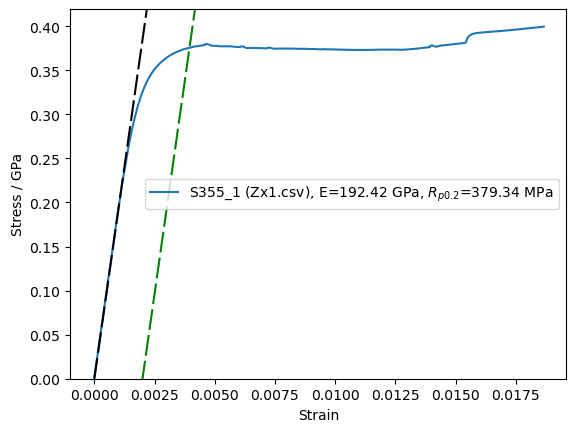

In [19]:
fig, ax = plt.subplots(1,1)
ax.plot(job.input.strain, job.input.stress/1e+09, label=testname+" ("+fname+r"), E={0:.2f} GPa, $R_{{p0.2}}$={1:.2f} MPa".format(E/1e+09, Rp02/1e+06))
ax.set_ylim(bottom=-0.0)
ax.set_xlim(left=-0.001)
ax.set_xlabel('Strain')
ax.set_ylabel('Stress / GPa')

# plot lines indicating the calculation of E and Rp0.2
ax.plot(job.input.strain, E*job.input.strain/1e+09, label=None, color='k', dashes=(10.,2.5))
ax.plot(job.input.strain, E*(job.input.strain-0.002)/1e+09, label=None, color='g', dashes=(10.,2.5))
ax.legend()

## Perform a batch analisis of all available tensile tests

In [20]:
pr = Project('tensiletest_batch_analysis')
pr.remove_jobs(silently=True)

  0%|          | 0/10 [00:00<?, ?it/s]

The job tensile_job_S355_10 was saved and received the ID: 78
The job tensile_job_S355_1 was saved and received the ID: 79
The job tensile_job_S355_2 was saved and received the ID: 80
The job tensile_job_S355_3 was saved and received the ID: 81
The job tensile_job_S355_4 was saved and received the ID: 82
The job tensile_job_S355_5 was saved and received the ID: 83
The job tensile_job_S355_6 was saved and received the ID: 84
The job tensile_job_S355_7 was saved and received the ID: 85
The job tensile_job_S355_8 was saved and received the ID: 86
The job tensile_job_S355_9 was saved and received the ID: 87


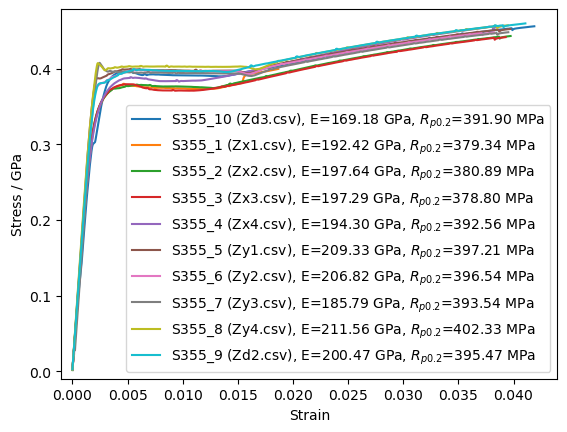

In [21]:
fig, ax = plt.subplots(1,1)
for uri in uris:
    # generate a nice identifier for the jobs - not actually neccessary
    jobstr = uri.replace('https://w3id.org/pmd/ao/tte/pmdao-tto-tt-', '')
    jobstr = jobstr.replace('_process', '')
    jobstr = jobstr.replace('-', '_') # pyiron doesn't like hyphens

    job = pr.create.job.TensileJob(job_name='tensile_job_'+jobstr, delete_existing_job=True)
    
    job.endpoint = SPARQL_ENDPOINT
    job.access_token = TOKEN
    job.uri = uri

    job.query_cross_section_area()
    job.query_raw_data_url()
    job.load_force_and_strain()
    job.calc_stress()

    # calculate E and Rp02
    job.run()
    
    E = job.output.elastic_modulus
    Rp02 = job.output.Rp02

    fname = job.input.raw_data_url[-7:]
    
    ax.plot(job.input.strain, job.input.stress/1e+09, label=jobstr+" ("+fname+r"), E={0:.2f} GPa, $R_{{p0.2}}$={1:.2f} MPa".format(E/1e+09, Rp02/1e+06))
    ax.set_ylim(bottom=-0.01)
    ax.set_xlim(left=-0.001)
    ax.set_xlabel('Strain')
    ax.set_ylabel('Stress / GPa')
    ax.legend()
#pr.job_table()